In [ ]:
# Welcome to your new notebook
# Type here in the cell editor to add code!


In [ ]:
# Import libraries
from vnstock import *
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta


In [ ]:
# Define date range for historical data
end_date = '2025-04-02'
start_date = '2015-01-01'

# Step 1: Get Vietnam stock data using vnstock3
# Initialize Vnstock client for VNINDEX
stock = Vnstock().stock(symbol='VNINDEX', source='TCBS')

# Fetch historical data for VNINDEX
vn_stock_data = stock.quote.history(start=start_date, end=end_date)


In [ ]:
vn_stock_data= vn_stock_data.drop_duplicates(subset=['time'])

In [ ]:
# Kiểm tra số dòng theo ngày
print(vn_stock_data['time'].value_counts().sort_values(ascending=False).head())

# Xem ngày có hơn 1 dòng
multiple_rows_tcb = vn_stock_data[vn_stock_data['time'].duplicated(keep=False)]
print(multiple_rows_tcb.sort_values('time'))


In [ ]:
vn_stock_data

In [ ]:

vn_stock_data= vn_stock_data.rename(columns={'time': 'date'})


In [ ]:
# Define tickers
tickers = {
    'Dow_Jones': '^DJI',
    'VND_USD': 'USDVND=X'
}

# Define date range
end_date = '2025-04-02'
start_date = '2015-01-05'
# Initialize DataFrames for each ticker

DJ_df = None
usdvnd_df = None

# Loop through tickers to fetch data
for name, ticker in tickers.items():
    try:
        # Download data
        data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
        if not data.empty:
            # Reset index to make 'Date' a column and select only 'Date' and 'Close'
            data = data.reset_index()[['Date', 'Close']]
            # Làm phẳng MultiIndex columns (nếu có)
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = ['_'.join(col).strip() for col in data.columns.values]
            # Rename 'Close' to match requirement
            data = data.rename(columns={'Close': 'close'})
            # Assign to respective DataFrame based on name
            
            if name == 'Dow_Jones':
                DJ_df = data
            elif name == 'VND_USD':
                usdvnd_df = data
        else:
            print(f"No data found for {name} ({ticker})")
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

In [ ]:
DJ_df.info()

In [ ]:

DJ_df

In [ ]:
usdvnd_df.info()

In [ ]:
usdvnd_df

In [ ]:

DJ_df=DJ_df.rename(columns={
    'Date_':'date',
    'Close_^DJI':'DJI_close'
})
usdvnd_df=usdvnd_df.rename(columns={
    'Date_':'date',
    'Close_USDVND=X':'USD/VND'
})


In [ ]:
vn_stock_data.info()


In [ ]:
# Ensure column names are consistent
# Rename 'date' to 'Date' in vn_stock_data if necessary
vn_stock_data = vn_stock_data.rename(columns={'date': 'date', 'close': 'vnindex_close'})

# Ensure 'Date' column is in datetime format for all DataFrames

DJ_df['date'] = pd.to_datetime(DJ_df['date'])
usdvnd_df['date'] = pd.to_datetime(usdvnd_df['date'])
vn_stock_data['date'] = pd.to_datetime(vn_stock_data['date'])



# Merge DataFrames with left join on vn_stock_data['date']
merged_df = vn_stock_data[['date', 'vnindex_close']].merge(
    DJ_df[['date', 'DJI_close']], on='date', how='left'
).merge(
    usdvnd_df[['date', 'USD/VND']], on='date', how='left'
)

# Sort by date
# merged_df = merged_df.sort_values('date')

# # Reset index for cleaner output
# merged_df = merged_df.reset_index(drop=True)

# # Filter merged DataFrame for business days only
# merged_df = merged_df[merged_df['date'].dt.dayofweek < 5]



In [ ]:
merged_df

In [ ]:
merged_df=merged_df.ffill()

In [ ]:
merged_df.info()

In [ ]:
merged_df['unique_id'] = 'VNINDEX'
merged_df = merged_df.rename(columns={'date': 'ds','vnindex_close': 'y' })  # Chuyển 'date' thành 'ds'
merged_df['ds'] = pd.to_datetime(merged_df['ds'])  # Chuyển sang datetime
merged_df = merged_df[['unique_id', 'ds', 'y', 'USD/VND','DJI_close']]  # Đổi OT thành y


In [ ]:
merged_df

In [ ]:


output_path = 'D:\DATN\vnindex_with_usd_dji_gold_oil.csv'



merged_df.to_csv(output_path, index=False)

# Print success message
print(f"Data successfully saved to {output_path}")
print("Sample of combined data:")
print(merged_df.head())

In [ ]:
df= pd.read_csv(r'D:\DATN\vnindex_with_usd_dji_gold_oil.csv')
df
df.info()

In [ ]:
df.drop_duplicates

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


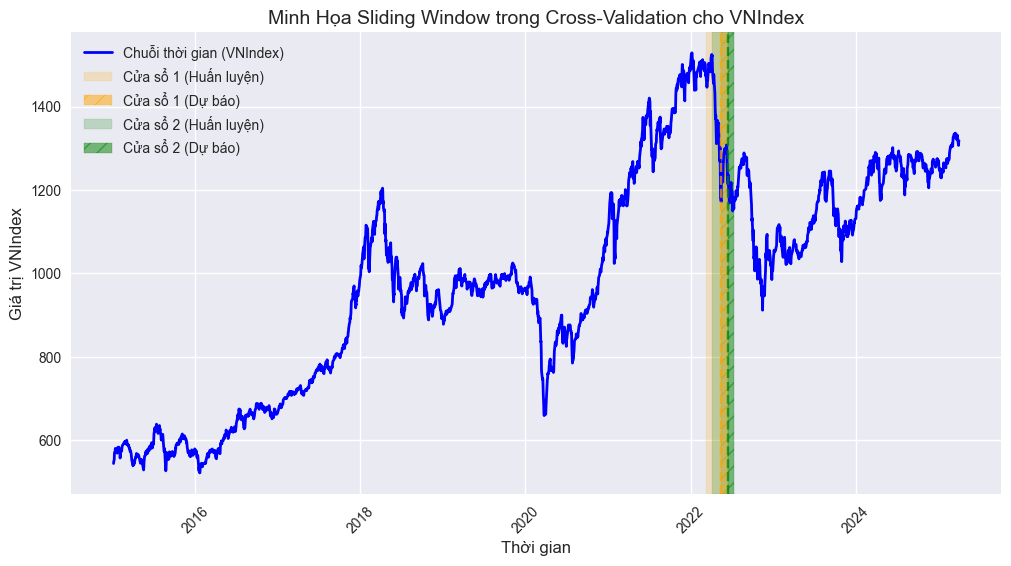

In [65]:

import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu thực từ file CSV
data_path = r'D:\DATN\final code\vnindex_with_usd_dji_gold_oil.csv'
df = pd.read_csv(data_path)

# Giả định cột chứa giá đóng cửa VNIndex là 'VNINDEX_Close' và cột thời gian là 'Date'
# Kiểm tra tên cột thực tế bằng: print(df.columns)
vnindex_col = 'OT'  # Thay bằng tên cột thực tế nếu khác
time_col = 'date'  # Thay bằng tên cột thời gian nếu khác

# Chuyển đổi cột thời gian sang định dạng datetime
df[time_col] = pd.to_datetime(df[time_col])
time = df[time_col]
data = df[vnindex_col]

# Xử lý giá trị null (nếu có) bằng ffill, như trong đồ án
data = data.fillna(method='ffill')

# Thông số từ đoạn code
train_size = 1789  # Số ngày làm việc trong tập huấn luyện
val_size = 511    # Số ngày làm việc trong tập xác thực
test_size = 256   # Số ngày làm việc trong tập kiểm tra
horizon = 20      # Số bước dự báo (20 ngày làm việc)
step_size = horizon  # Bước dịch chuyển giữa các cửa sổ
input_size = 45   # Kích thước cửa sổ huấn luyện (giả định, lấy từ final_params['input_size'])
n_windows = 2  # Số lượng cửa sổ hiển thị (để minh họa)

# Tính tổng số điểm thời gian
time_steps = len(data)

# Kiểm tra tính hợp lệ của dữ liệu
if time_steps != train_size + val_size + test_size:
    print(f"Cảnh báo: Tổng số điểm thời gian ({time_steps}) không khớp với train_size + val_size + test_size ({train_size + val_size + test_size})")
    df = df.iloc[:train_size + val_size + test_size]
    time = df[time_col]
    data = df[vnindex_col]

# Thiết lập biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Chuỗi thời gian (VNIndex)', color='blue', linewidth=2)

# Minh họa các cửa sổ sliding window trong tập xác thực và kiểm tra
start_offset = train_size  # Bắt đầu từ cuối tập huấn luyện
colors = ['orange', 'green']  # Màu cho các cửa sổ
for i in range(n_windows):
    start = start_offset + i * step_size
    train_start = start  # Bắt đầu cửa sổ huấn luyện
    train_end = start + input_size  # Kết thúc cửa sổ huấn luyện
    forecast_end = train_end + horizon  # Kết thúc cửa sổ dự báo
    
    # Kiểm tra giới hạn dữ liệu
    if forecast_end > time_steps:
        break
    
    # Vẽ cửa sổ huấn luyện
    plt.axvspan(time[train_start], time[train_end], alpha=0.2, color=colors[i], 
                label=f'Cửa sổ {i+1} (Huấn luyện)' )
    # Vẽ cửa sổ dự báo
    plt.axvspan(time[train_end], time[forecast_end], alpha=0.5, color=colors[i], 
                hatch='//', label=f'Cửa sổ {i+1} (Dự báo)' )
    
    # Thêm đường phân cách giữa huscaras: huấn luyện và dự báo
    plt.axvline(x=time[train_end], color=colors[i], linestyle='--', alpha=0.7)

# Thiết lập tiêu đề và nhãn
plt.title('Minh Họa Sliding Window trong Cross-Validation cho VNIndex', fontsize=14)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá trị VNIndex', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)

# Xoay nhãn trục x để dễ đọc
plt.xticks(rotation=45)

# Lưu biểu đồ
plt.savefig('sliding_window_cross_validation_vnindex.png', dpi=300, bbox_inches='tight')
plt.show()





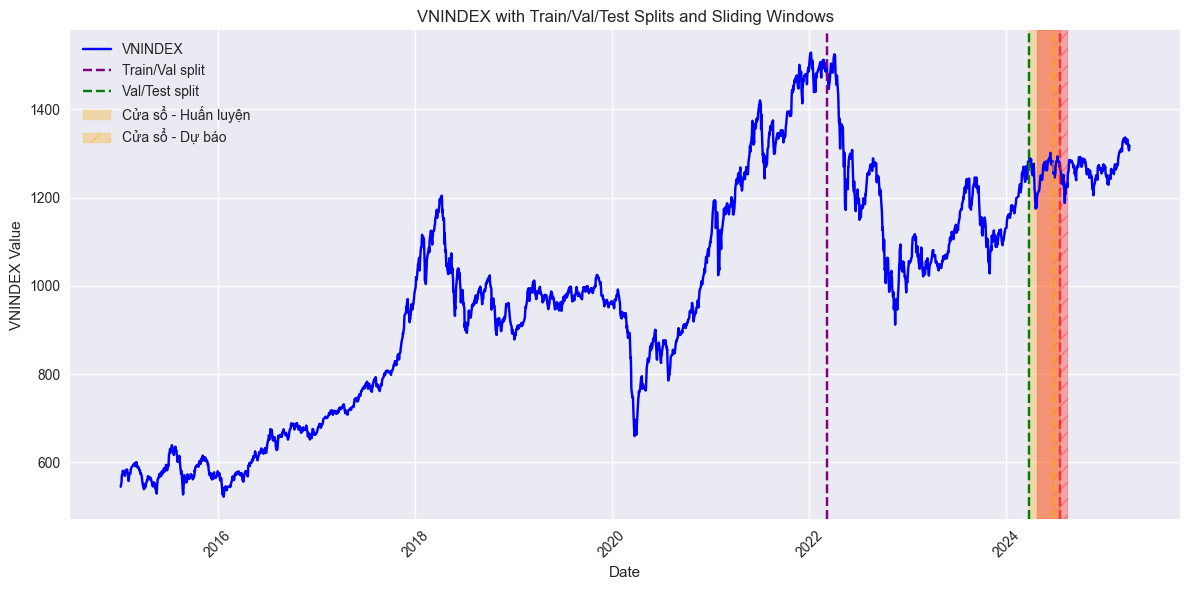

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu
data_path = r'D:\DATN\final code\vnindex_with_usd_dji_gold_oil.csv'
df = pd.read_csv(data_path)

# Giả định cột chứa giá đóng cửa VNIndex là 'OT' và cột thời gian là 'date'
vnindex_col = 'OT'  # Tên cột giá trị VNINDEX
time_col = 'date'   # Tên cột thời gian
# Chuyển đổi cột thời gian sang định dạng datetime
df[time_col] = pd.to_datetime(df[time_col])
time = df[time_col]
data = df[vnindex_col]

# Tham số sliding window
input_size = 60
horizon = 20
step_size = horizon

# Tính toán kích thước các tập
train_size = int(len(df) * 0.7)
val_len = int(len(df) * 0.2)
test_len = len(df) - train_size - val_len
val_end = train_size + val_len

# Tính số cửa sổ dựa trên test_size và step_size
test_size = test_len - ((test_len - horizon) % horizon)  # Điều chỉnh như trong cross_validation
n_windows = 2
# n_windows = test_size // step_size  # Số cửa sổ thực tế

# Tạo biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(time, data, color='blue', label='VNINDEX')

# Vẽ đường phân chia train/val/test
plt.axvline(x=time[train_size], color='purple', linestyle='--', label='Train/Val split')
plt.axvline(x=time[val_end], color='green', linestyle='--', label='Val/Test split')

# Định nghĩa màu sắc cho cửa sổ
colors = ['orange', 'red']

# Vẽ các cửa sổ trượt trong tập test
start_offset = val_end  # Bắt đầu từ tập test
legend_added = {'train': False, 'forecast': False}  # Theo dõi nhãn legend

for i in range(n_windows):
    start_idx = start_offset + i * step_size
    train_start = start_idx
    train_end = start_idx + input_size
    forecast_end = train_end + horizon

    # Kiểm tra không vượt quá index
    if train_end >= len(df) or forecast_end > len(df):
        break

    # Vẽ cửa sổ huấn luyện
    plt.axvspan(time[train_start], time[train_end],
                alpha=0.3, color=colors[i % len(colors)],
                label='Cửa sổ - Huấn luyện' if not legend_added['train'] else None)
    legend_added['train'] = True

    # Vẽ cửa sổ dự báo
    plt.axvspan(time[train_end], time[forecast_end],
                alpha=0.3, color=colors[i % len(colors)], hatch='//',
                label='Cửa sổ - Dự báo' if not legend_added['forecast'] else None)
    legend_added['forecast'] = True

    # Vẽ đường phân tách giữa huấn luyện và dự báo
    plt.axvline(x=time[train_end], color=colors[i % len(colors)], linestyle='--', alpha=0.6)

# Thêm nhãn và tiêu đề
plt.xlabel('Date')
plt.ylabel('VNINDEX Value')
plt.title('VNINDEX with Train/Val/Test Splits and Sliding Windows')
plt.legend(loc='upper left')
plt.grid(True)

# Định dạng trục x cho ngày tháng
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tổng dữ liệu: 2556
Train: 0-1788 (1789 điểm)
Validation: 1789-2299 (511 điểm)
Test: 2300-2555 (256 điểm)
Số cửa sổ CV: 12


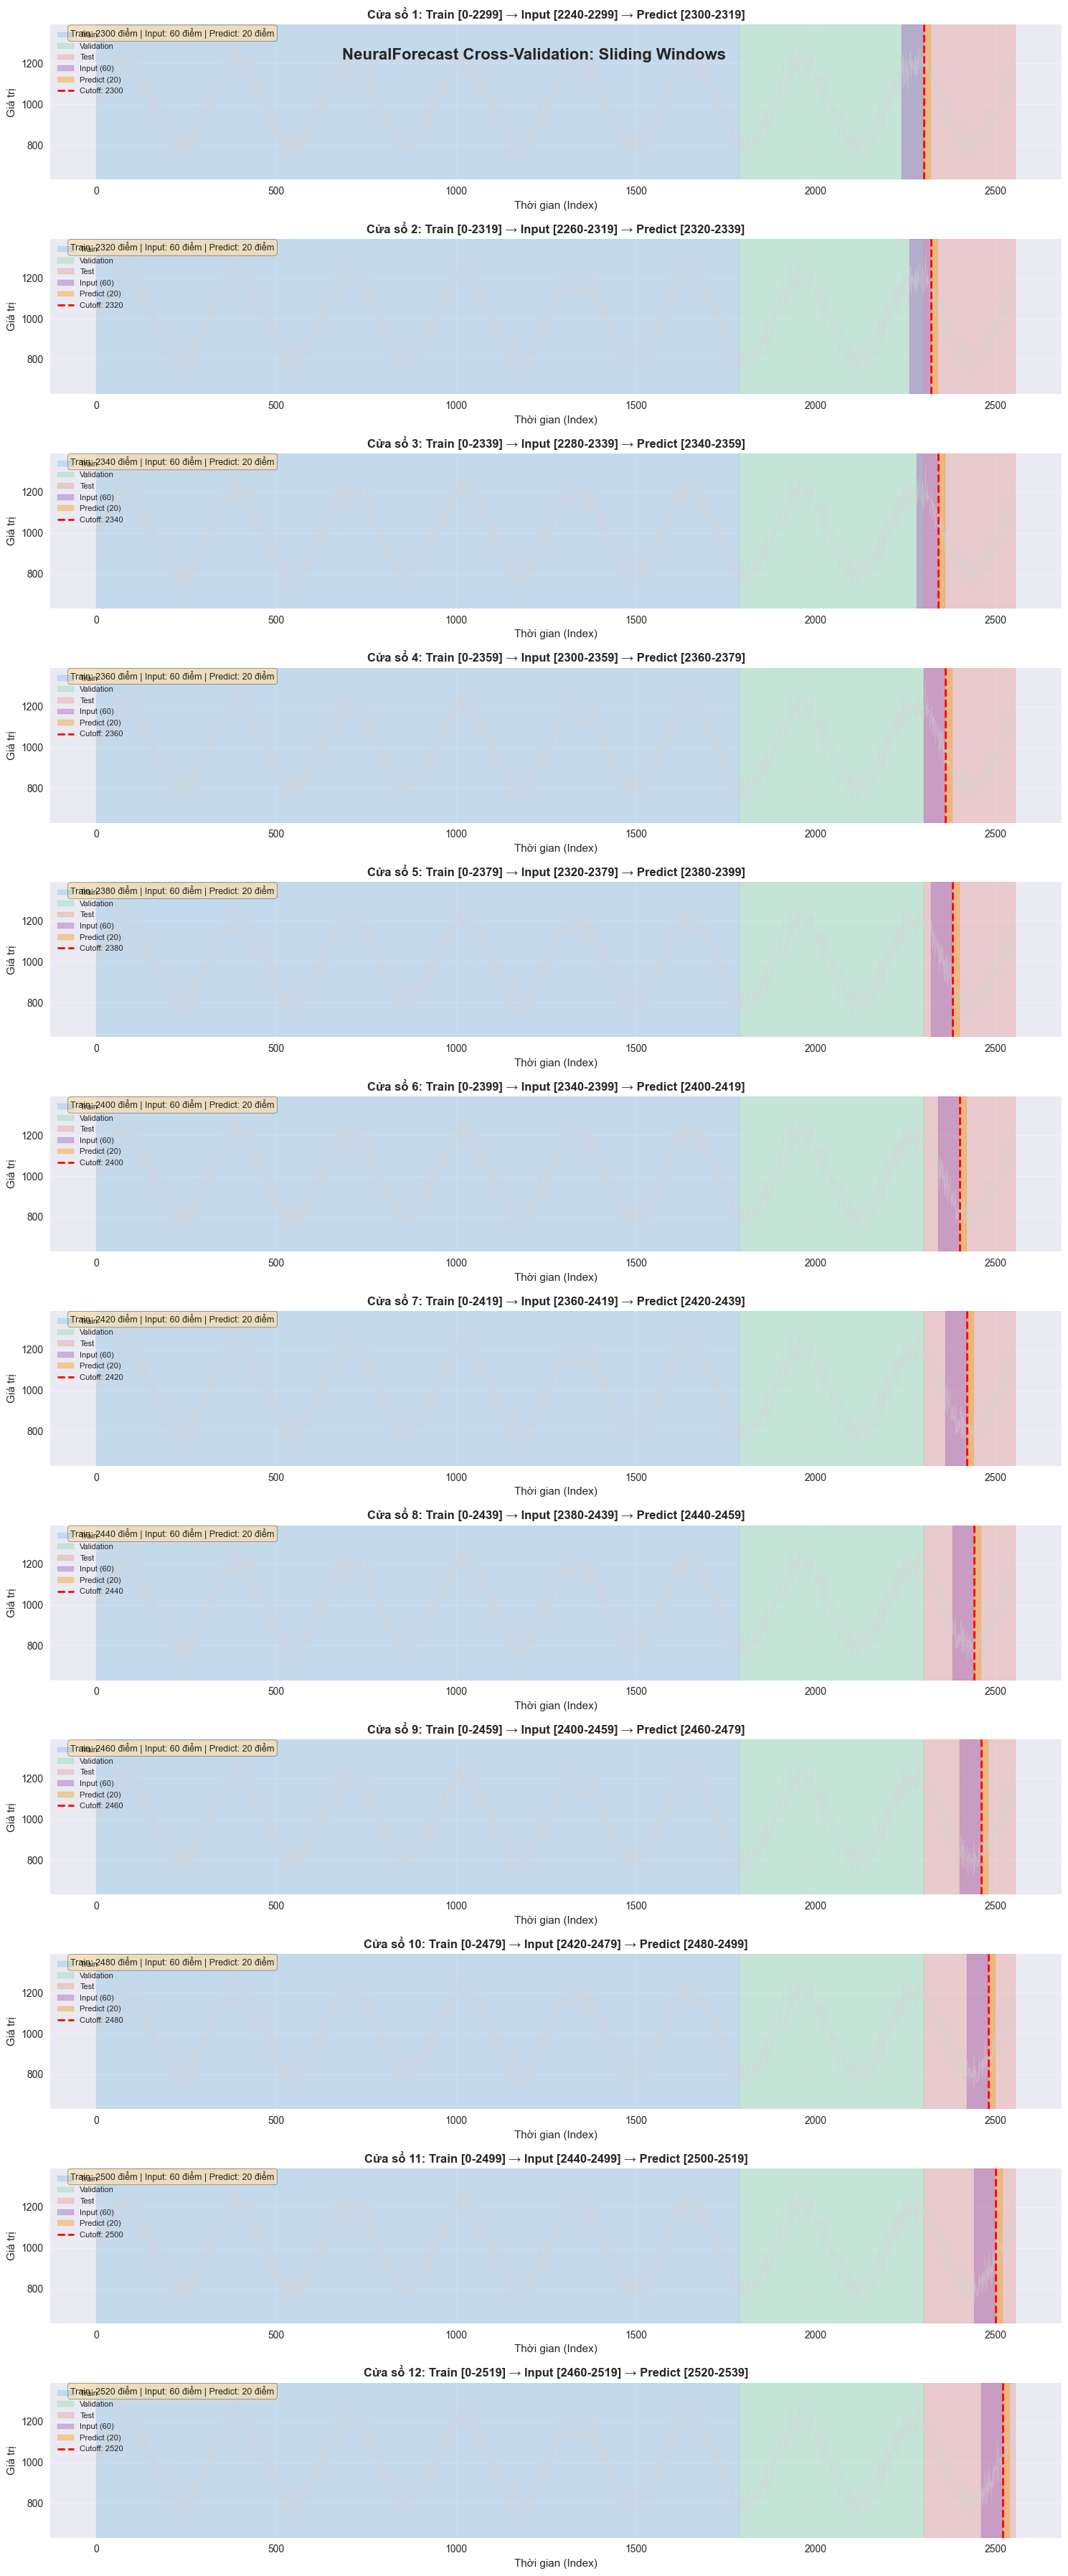


CHI TIẾT CÁC CỬA SỔ CROSS-VALIDATION

Cửa sổ 1 (Cutoff: 2300):
  - Train:   [   0 - 2299] = 2300 điểm
  - Input:   [2240 - 2299] =   60 điểm
  - Predict: [2300 - 2319] =   20 điểm

Cửa sổ 2 (Cutoff: 2320):
  - Train:   [   0 - 2319] = 2320 điểm
  - Input:   [2260 - 2319] =   60 điểm
  - Predict: [2320 - 2339] =   20 điểm

Cửa sổ 3 (Cutoff: 2340):
  - Train:   [   0 - 2339] = 2340 điểm
  - Input:   [2280 - 2339] =   60 điểm
  - Predict: [2340 - 2359] =   20 điểm

Cửa sổ 4 (Cutoff: 2360):
  - Train:   [   0 - 2359] = 2360 điểm
  - Input:   [2300 - 2359] =   60 điểm
  - Predict: [2360 - 2379] =   20 điểm

Cửa sổ 5 (Cutoff: 2380):
  - Train:   [   0 - 2379] = 2380 điểm
  - Input:   [2320 - 2379] =   60 điểm
  - Predict: [2380 - 2399] =   20 điểm

Cửa sổ 6 (Cutoff: 2400):
  - Train:   [   0 - 2399] = 2400 điểm
  - Input:   [2340 - 2399] =   60 điểm
  - Predict: [2400 - 2419] =   20 điểm

Cửa sổ 7 (Cutoff: 2420):
  - Train:   [   0 - 2419] = 2420 điểm
  - Input:   [2360 - 2419] =   60 điểm


In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tham số từ code của bạn
data_path = r'D:\DATN\final code\vnindex_with_usd_dji_gold_oil.csv'
df = pd.read_csv(data_path)
total_data = len(df)

# Tính toán kích thước các tập
train_size = int(len(df) * 0.7)
val_len = int(len(df) * 0.2)
test_len = len(df) - train_size - val_len
val_end = train_size + val_len

input_size = 60
horizon = 20
step_size = horizon

# Tính toán các điểm quan trọng
val_end = train_size + val_len  # 900
test_size_adjusted = test_len - ((test_len - horizon) % horizon)  # 100
num_windows = test_size_adjusted // step_size  # 5

print(f"Tổng dữ liệu: {total_data}")
print(f"Train: 0-{train_size-1} ({train_size} điểm)")
print(f"Validation: {train_size}-{val_end-1} ({val_len} điểm)")
print(f"Test: {val_end}-{total_data-1} ({test_len} điểm)")
print(f"Số cửa sổ CV: {num_windows}")

# Tạo dữ liệu mẫu
np.random.seed(42)
data = 1000 + np.sin(np.arange(total_data) / 50) * 200 + np.random.normal(0, 50, total_data)

# Vẽ biểu đồ
fig, axes = plt.subplots(num_windows, 1, figsize=(15, 3*num_windows))
if num_windows == 1:
    axes = [axes]

colors = {
    'train': '#3498db',      # Blue
    'validation': '#2ecc71', # Green  
    'test': '#e74c3c',       # Red
    'input': '#9b59b6',      # Purple
    'predict': '#f39c12'     # Orange
}

for i in range(num_windows):
    ax = axes[i]
    
    # Tính toán cho cửa sổ hiện tại
    cutoff = val_end + i * step_size
    train_end = cutoff - 1
    input_start = cutoff - input_size
    input_end = cutoff - 1
    pred_start = cutoff
    pred_end = cutoff + horizon - 1
    
    # Vẽ toàn bộ dữ liệu
    ax.plot(range(total_data), data, 'lightgray', alpha=0.5, linewidth=0.5)
    
    # Vẽ các vùng dữ liệu
    # Train
    ax.axvspan(0, train_size, alpha=0.2, color=colors['train'], label='Train')
    # Validation
    ax.axvspan(train_size, val_end, alpha=0.2, color=colors['validation'], label='Validation')
    # Test
    ax.axvspan(val_end, total_data, alpha=0.2, color=colors['test'], label='Test')
    
    # Highlight cửa sổ hiện tại
    # Input window
    ax.axvspan(input_start, input_end+1, alpha=0.4, color=colors['input'], label=f'Input ({input_size})')
    # Prediction window
    ax.axvspan(pred_start, pred_end+1, alpha=0.4, color=colors['predict'], label=f'Predict ({horizon})')
    
    # Vẽ đường cutoff
    ax.axvline(cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff: {cutoff}')
    
    # Thiết lập tiêu đề và nhãn
    ax.set_title(f'Cửa sổ {i+1}: Train [0-{train_end}] → Input [{input_start}-{input_end}] → Predict [{pred_start}-{pred_end}]', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Thời gian (Index)')
    ax.set_ylabel('Giá trị')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Hiển thị thông tin chi tiết
    info_text = f'Train: {train_end+1} điểm | Input: {input_size} điểm | Predict: {horizon} điểm'
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.suptitle('NeuralForecast Cross-Validation: Sliding Windows', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# In thông tin chi tiết về các cửa sổ
print("\n" + "="*80)
print("CHI TIẾT CÁC CỬA SỔ CROSS-VALIDATION")
print("="*80)
for i in range(num_windows):
    cutoff = val_end + i * step_size
    train_end = cutoff - 1
    input_start = cutoff - input_size
    input_end = cutoff - 1
    pred_start = cutoff
    pred_end = cutoff + horizon - 1
    
    print(f"\nCửa sổ {i+1} (Cutoff: {cutoff}):")
    print(f"  - Train:   [{0:4d} - {train_end:4d}] = {train_end+1:4d} điểm")
    print(f"  - Input:   [{input_start:4d} - {input_end:4d}] = {input_size:4d} điểm")
    print(f"  - Predict: [{pred_start:4d} - {pred_end:4d}] = {horizon:4d} điểm")

print(f"\nTổng kết:")
print(f"- Mỗi cửa sổ cách nhau {step_size} điểm")
print(f"- Không có chồng lấn vì step_size = horizon")
print(f"- Test set được sử dụng hoàn toàn: {num_windows} × {horizon} = {num_windows * horizon} điểm")

=== THÔNG TIN DỮ LIỆU ===
Tổng số điểm dữ liệu: 2556
Kích thước tập train: 1789
Kích thước tập validation: 511
Kích thước tập test gốc: 256
Kích thước tập test đã điều chỉnh: 240
Số cửa sổ cross-validation: 12
Input size (lookback): 60
Horizon (forecast): 20
Step size: 20


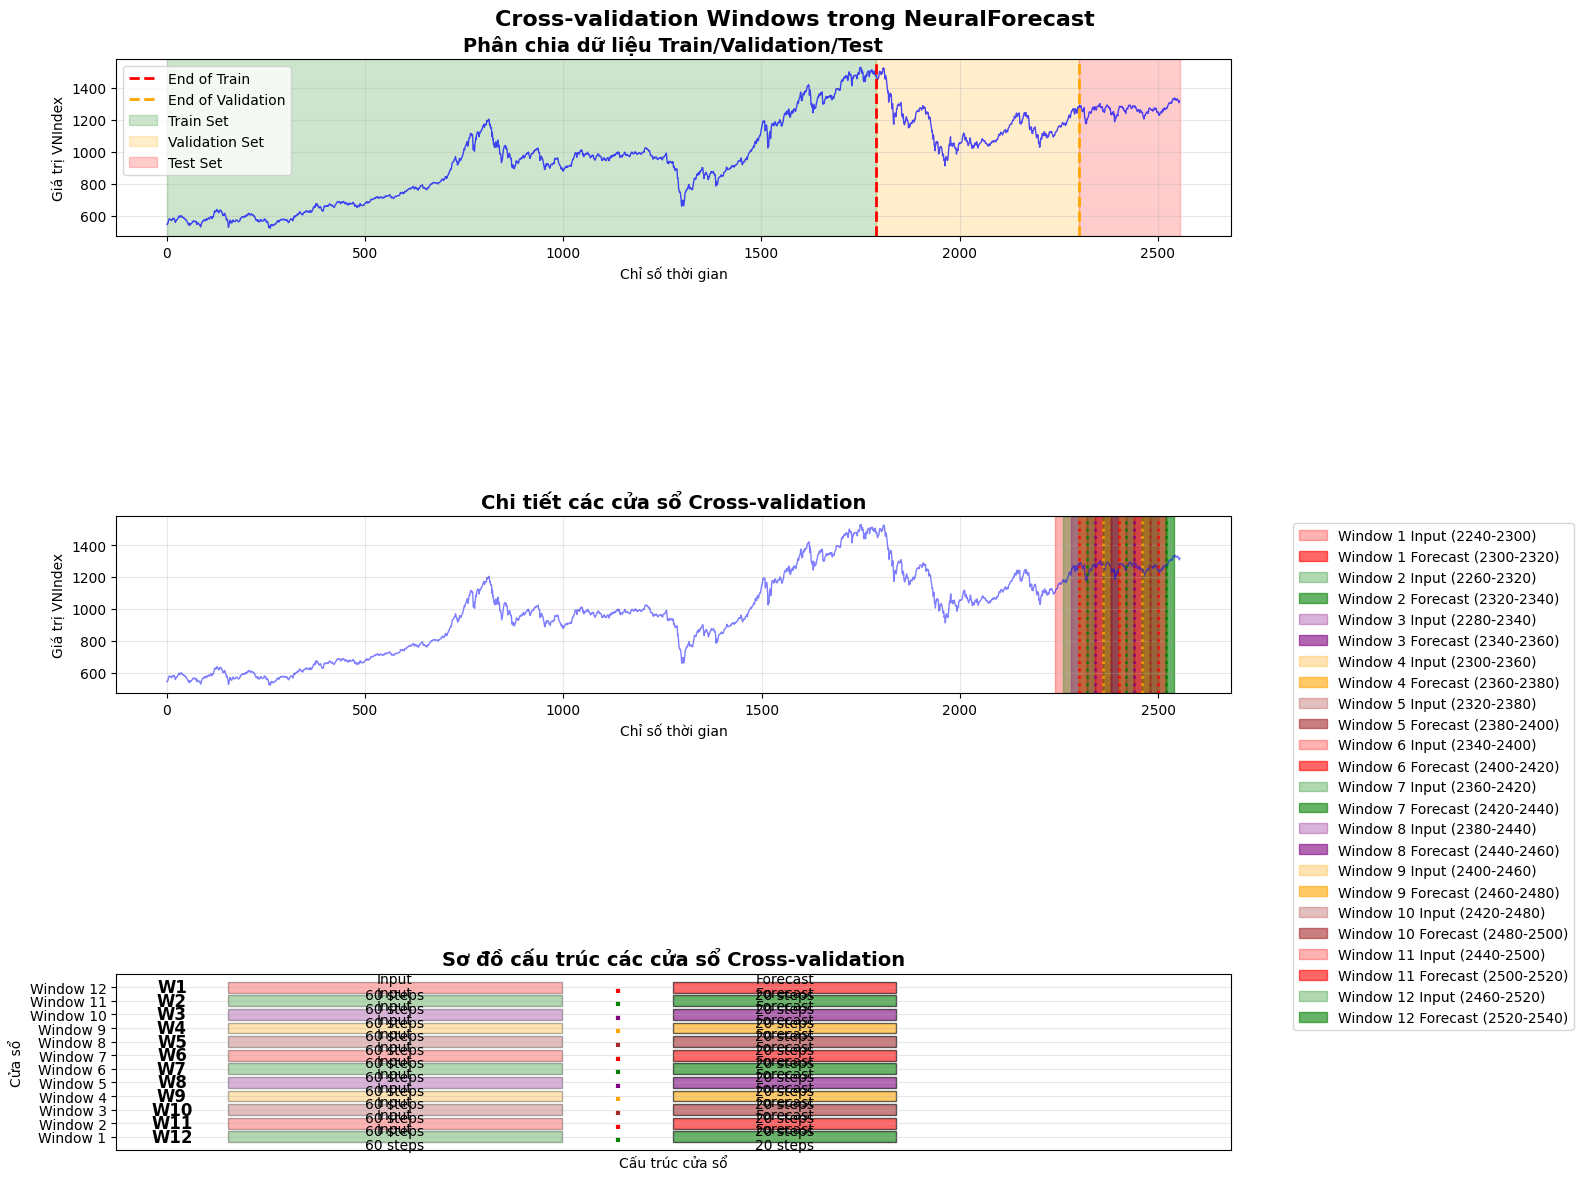


=== CHI TIẾT CÁC CỬA SỔ CROSS-VALIDATION ===

Cửa sổ 1:
  - Cutoff point: 2300
  - Input window: [2240, 2300] (60 steps)
  - Forecast window: [2300, 2320] (20 steps)
  - Ngày cutoff: 2024-03-25
  - Ngày forecast cuối: 2024-04-22

Cửa sổ 2:
  - Cutoff point: 2320
  - Input window: [2260, 2320] (60 steps)
  - Forecast window: [2320, 2340] (20 steps)
  - Ngày cutoff: 2024-04-23
  - Ngày forecast cuối: 2024-05-23

Cửa sổ 3:
  - Cutoff point: 2340
  - Input window: [2280, 2340] (60 steps)
  - Forecast window: [2340, 2360] (20 steps)
  - Ngày cutoff: 2024-05-24
  - Ngày forecast cuối: 2024-06-20

Cửa sổ 4:
  - Cutoff point: 2360
  - Input window: [2300, 2360] (60 steps)
  - Forecast window: [2360, 2380] (20 steps)
  - Ngày cutoff: 2024-06-21
  - Ngày forecast cuối: 2024-07-18

Cửa sổ 5:
  - Cutoff point: 2380
  - Input window: [2320, 2380] (60 steps)
  - Forecast window: [2380, 2400] (20 steps)
  - Ngày cutoff: 2024-07-19
  - Ngày forecast cuối: 2024-08-15

Cửa sổ 6:
  - Cutoff point: 2400



## 👋 Chào mừng bạn đến với Vnstock!

Cảm ơn bạn đã sử dụng package phân tích chứng khoán #1 tại Việt Nam

* Tài liệu: [vnstocks.com/docs](https://vnstocks.com/docs)
* Cộng đồng: [vnstocks.com/community](https://vnstocks.com/community)

Khám phá các tính năng mới nhất và tham gia cộng đồng để nhận hỗ trợ.
            

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

# Thiết lập style cho plot
plt.style.use('default')
sns.set_palette("husl")

# Đọc dữ liệu
data_path = r'D:\DATN\final code\vnindex_with_usd_dji_gold_oil.csv'
df = pd.read_csv(data_path)

# Giả định cột chứa giá đóng cửa VNIndex là 'OT' và cột thời gian là 'date'
vnindex_col = 'OT'  # Tên cột giá trị VNINDEX
time_col = 'date'   # Tên cột thời gian

# Chuyển đổi cột thời gian sang định dạng datetime
df[time_col] = pd.to_datetime(df[time_col])
time = df[time_col]
data = df[vnindex_col]

# Tham số sliding window
input_size = 60
horizon = 20
step_size = horizon

# Tính toán kích thước các tập
train_size = int(len(df) * 0.7)
val_len = int(len(df) * 0.2)
test_len = len(df) - train_size - val_len
val_end = train_size + val_len

# Tính toán test_size cho cross-validation (đảm bảo chia hết cho horizon)
adjusted_test_size = test_len - ((test_len - horizon) % horizon)
n_windows = adjusted_test_size // horizon  # Số cửa sổ cross-validation

print("=== THÔNG TIN DỮ LIỆU ===")
print(f"Tổng số điểm dữ liệu: {len(df)}")
print(f"Kích thước tập train: {train_size}")
print(f"Kích thước tập validation: {val_len}")
print(f"Kích thước tập test gốc: {test_len}")
print(f"Kích thước tập test đã điều chỉnh: {adjusted_test_size}")
print(f"Số cửa sổ cross-validation: {n_windows}")
print(f"Input size (lookback): {input_size}")
print(f"Horizon (forecast): {horizon}")
print(f"Step size: {step_size}")

# Tạo visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Cross-validation Windows trong NeuralForecast', fontsize=16, fontweight='bold')

# 1. Tổng quan phân chia dữ liệu
ax1 = axes[0]
ax1.plot(range(len(df)), data.values, 'b-', alpha=0.7, linewidth=1)
ax1.axvline(x=train_size, color='red', linestyle='--', linewidth=2, label='End of Train')
ax1.axvline(x=val_end, color='orange', linestyle='--', linewidth=2, label='End of Validation')

# Highlight các phần
ax1.axvspan(0, train_size, alpha=0.2, color='green', label='Train Set')
ax1.axvspan(train_size, val_end, alpha=0.2, color='orange', label='Validation Set')
ax1.axvspan(val_end, len(df), alpha=0.2, color='red', label='Test Set')

ax1.set_title('Phân chia dữ liệu Train/Validation/Test', fontsize=14, fontweight='bold')
ax1.set_xlabel('Chỉ số thời gian')
ax1.set_ylabel('Giá trị VNIndex')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Chi tiết các cửa sổ cross-validation
ax2 = axes[1]
ax2.plot(range(len(df)), data.values, 'b-', alpha=0.5, linewidth=1)

# Vẽ các cửa sổ cross-validation
colors = ['red', 'green', 'purple', 'orange', 'brown']
test_start = val_end

for i in range(n_windows):
    # Tính toán vị trí cửa sổ
    cutoff_point = test_start + i * step_size
    forecast_start = cutoff_point
    forecast_end = forecast_start + horizon
    
    # Input window (lookback)
    input_start = max(0, cutoff_point - input_size)
    input_end = cutoff_point
    
    color = colors[i % len(colors)]
    
    # Vẽ input window
    ax2.axvspan(input_start, input_end, alpha=0.3, color=color, 
                label=f'Window {i+1} Input ({input_start}-{input_end})')
    
    # Vẽ forecast window
    ax2.axvspan(forecast_start, forecast_end, alpha=0.6, color=color,
                label=f'Window {i+1} Forecast ({forecast_start}-{forecast_end})')
    
    # Vẽ đường cutoff
    ax2.axvline(x=cutoff_point, color=color, linestyle=':', linewidth=2, alpha=0.8)

ax2.set_title('Chi tiết các cửa sổ Cross-validation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Chỉ số thời gian')
ax2.set_ylabel('Giá trị VNIndex')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Sơ đồ minh họa cấu trúc cửa sổ
ax3 = axes[2]
ax3.set_xlim(0, 10)
ax3.set_ylim(0, n_windows + 1)

# Vẽ sơ đồ cho mỗi cửa sổ
for i in range(n_windows):
    y_pos = n_windows - i
    
    # Input window
    input_rect = Rectangle((1, y_pos-0.4), 3, 0.8, 
                          facecolor=colors[i % len(colors)], alpha=0.3, 
                          edgecolor='black', linewidth=1)
    ax3.add_patch(input_rect)
    
    # Forecast window
    forecast_rect = Rectangle((5, y_pos-0.4), 2, 0.8, 
                             facecolor=colors[i % len(colors)], alpha=0.6, 
                             edgecolor='black', linewidth=1)
    ax3.add_patch(forecast_rect)
    
    # Cutoff line
    ax3.axvline(x=4.5, ymin=(y_pos-0.4)/(n_windows+1), ymax=(y_pos+0.4)/(n_windows+1), 
                color=colors[i % len(colors)], linestyle=':', linewidth=3)
    
    # Labels
    ax3.text(2.5, y_pos, f'Input\n{input_size} steps', ha='center', va='center', fontsize=10)
    ax3.text(6, y_pos, f'Forecast\n{horizon} steps', ha='center', va='center', fontsize=10)
    ax3.text(0.5, y_pos, f'W{i+1}', ha='center', va='center', fontsize=12, fontweight='bold')

ax3.set_title('Sơ đồ cấu trúc các cửa sổ Cross-validation', fontsize=14, fontweight='bold')
ax3.set_xlabel('Cấu trúc cửa sổ')
ax3.set_ylabel('Cửa sổ')
ax3.set_xticks([])
ax3.set_yticks(range(1, n_windows + 1))
ax3.set_yticklabels([f'Window {i+1}' for i in range(n_windows)])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thông tin chi tiết về các cửa sổ
print("\n=== CHI TIẾT CÁC CỬA SỔ CROSS-VALIDATION ===")
for i in range(n_windows):
    cutoff_point = test_start + i * step_size
    forecast_start = cutoff_point
    forecast_end = forecast_start + horizon
    input_start = max(0, cutoff_point - input_size)
    input_end = cutoff_point
    
    print(f"\nCửa sổ {i+1}:")
    print(f"  - Cutoff point: {cutoff_point}")
    print(f"  - Input window: [{input_start}, {input_end}] ({input_end - input_start} steps)")
    print(f"  - Forecast window: [{forecast_start}, {forecast_end}] ({forecast_end - forecast_start} steps)")
    print(f"  - Ngày cutoff: {df.iloc[cutoff_point][time_col].strftime('%Y-%m-%d')}")
    print(f"  - Ngày forecast cuối: {df.iloc[min(forecast_end-1, len(df)-1)][time_col].strftime('%Y-%m-%d')}")

# Tạo DataFrame mô tả quá trình cross-validation
cv_info = []
for i in range(n_windows):
    cutoff_point = test_start + i * step_size
    forecast_start = cutoff_point
    forecast_end = forecast_start + horizon
    input_start = max(0, cutoff_point - input_size)
    input_end = cutoff_point
    
    cv_info.append({
        'Window': i+1,
        'Cutoff_Point': cutoff_point,
        'Input_Start': input_start,
        'Input_End': input_end,
        'Forecast_Start': forecast_start,
        'Forecast_End': forecast_end,
        'Cutoff_Date': df.iloc[cutoff_point][time_col].strftime('%Y-%m-%d'),
        'Forecast_End_Date': df.iloc[min(forecast_end-1, len(df)-1)][time_col].strftime('%Y-%m-%d')
    })

cv_df = pd.DataFrame(cv_info)
print("\n=== BẢNG TỔNG KẾT CÁC CỬA SỔ ===")
print(cv_df.to_string(index=False))

# Tạo mô tả về công thức tính toán
print("\n=== CÔNG THỨC TÍNH TOÁN ===")
print(f"test_size = test_len - ((test_len - horizon) % horizon)")
print(f"test_size = {test_len} - (({test_len} - {horizon}) % {horizon})")
print(f"test_size = {test_len} - ({test_len - horizon} % {horizon})")
print(f"test_size = {test_len} - {(test_len - horizon) % horizon}")
print(f"test_size = {adjusted_test_size}")
print(f"\nSố cửa sổ = test_size / step_size = {adjusted_test_size} / {step_size} = {n_windows}")